In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [4]:
from soundsig.sound import BioSound 

In [5]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

### Collect data

In [6]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins-biosound-features.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins-biosound-features.pickle')

In [8]:
biosound_features = {
    "f0 features": {
        "fund": "Mean F0 (Hz)",
        "cvfund": "Coeff. var. F0 (0-1)",
        "maxfund": "Min. F0 (Hz)",
        "minfund": "Max. F0 (Hz)",
        "F1": "First formant (Hz)",
        "sal": "Pitch saliency",
    },
    "intensity features": {
        "rms": "RMS (amp.)",
        "maxAmp": "Max  amplitude",
    },
    "spectral features": {
        "meanS": "Spectral mean  (Hz)",
        "stdS": "Spectral std.  (Hz)",
        "skewS": "Spectral skewness",
        "kurtS": "Spectral Kurtosis",
        "entS": "Spectral entropy (0-1)",
        "q1": "Spectral Q1 (Hz)",
        "q2": "Spectral Q2 (Hz)",
        "q3": "Spectral Q3 (Hz)",
    },
    "temporal features": {
        # temporal centroid for the temporal envelope
        "meanT": "Mean time (ms)",  
        "stdT": "Time Std. (ms)",
        "skewT": "Time Skewness",
        "kurtT": "Time Kurtosis",
        "entT": "Time entropy (0-1)",
    }
}

features = ["fund", "cvfund", "maxfund", "minfund", "sal"] + [
    "meanS", "stdS", "skewS", "kurtS", "entS", "q1", "q2", "q3"
] + ["meanT", "stdT", "skewT", "kurtT", "entT"]
len(features)

18

In [9]:
biosound_features.keys() 

dict_keys(['f0 features', 'intensity features', 'spectral features', 'temporal features'])

In [10]:
import pandas as pd

In [11]:
var_df = pd.DataFrame({i:[biosound_features[j][i], j] for i in features for j in biosound_features.keys() if i in biosound_features[j]}).T.reset_index()
var_df.columns = ['variable name', 'feature', 'feature type']

In [12]:
var_df

,variable name,feature,feature type
0,fund,Mean F0 (Hz),f0 features
1,cvfund,Coeff. var. F0 (0-1),f0 features
2,maxfund,Min. F0 (Hz),f0 features
3,minfund,Max. F0 (Hz),f0 features
4,sal,Pitch saliency,f0 features
5,meanS,Spectral mean (Hz),spectral features
6,stdS,Spectral std. (Hz),spectral features
7,skewS,Spectral skewness,spectral features
8,kurtS,Spectral Kurtosis,spectral features
9,entS,Spectral entropy (0-1),spectral features


In [13]:
print(var_df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
variable name &                 feature &       feature type \\
\midrule
         fund &            Mean F0 (Hz) &        f0 features \\
       cvfund &    Coeff. var. F0 (0-1) &        f0 features \\
      maxfund &            Min. F0 (Hz) &        f0 features \\
      minfund &            Max. F0 (Hz) &        f0 features \\
          sal &          Pitch saliency &        f0 features \\
        meanS &     Spectral mean  (Hz) &  spectral features \\
         stdS &     Spectral std.  (Hz) &  spectral features \\
        skewS &       Spectral skewness &  spectral features \\
        kurtS &       Spectral Kurtosis &  spectral features \\
         entS &  Spectral entropy (0-1) &  spectral features \\
           q1 &        Spectral Q1 (Hz) &  spectral features \\
           q2 &        Spectral Q2 (Hz) &  spectral features \\
           q3 &        Spectral Q3 (Hz) &  spectral features \\
        meanT &          Mean time (ms) &  temporal features \\
 

In [14]:
import matplotlib.image as mpimg

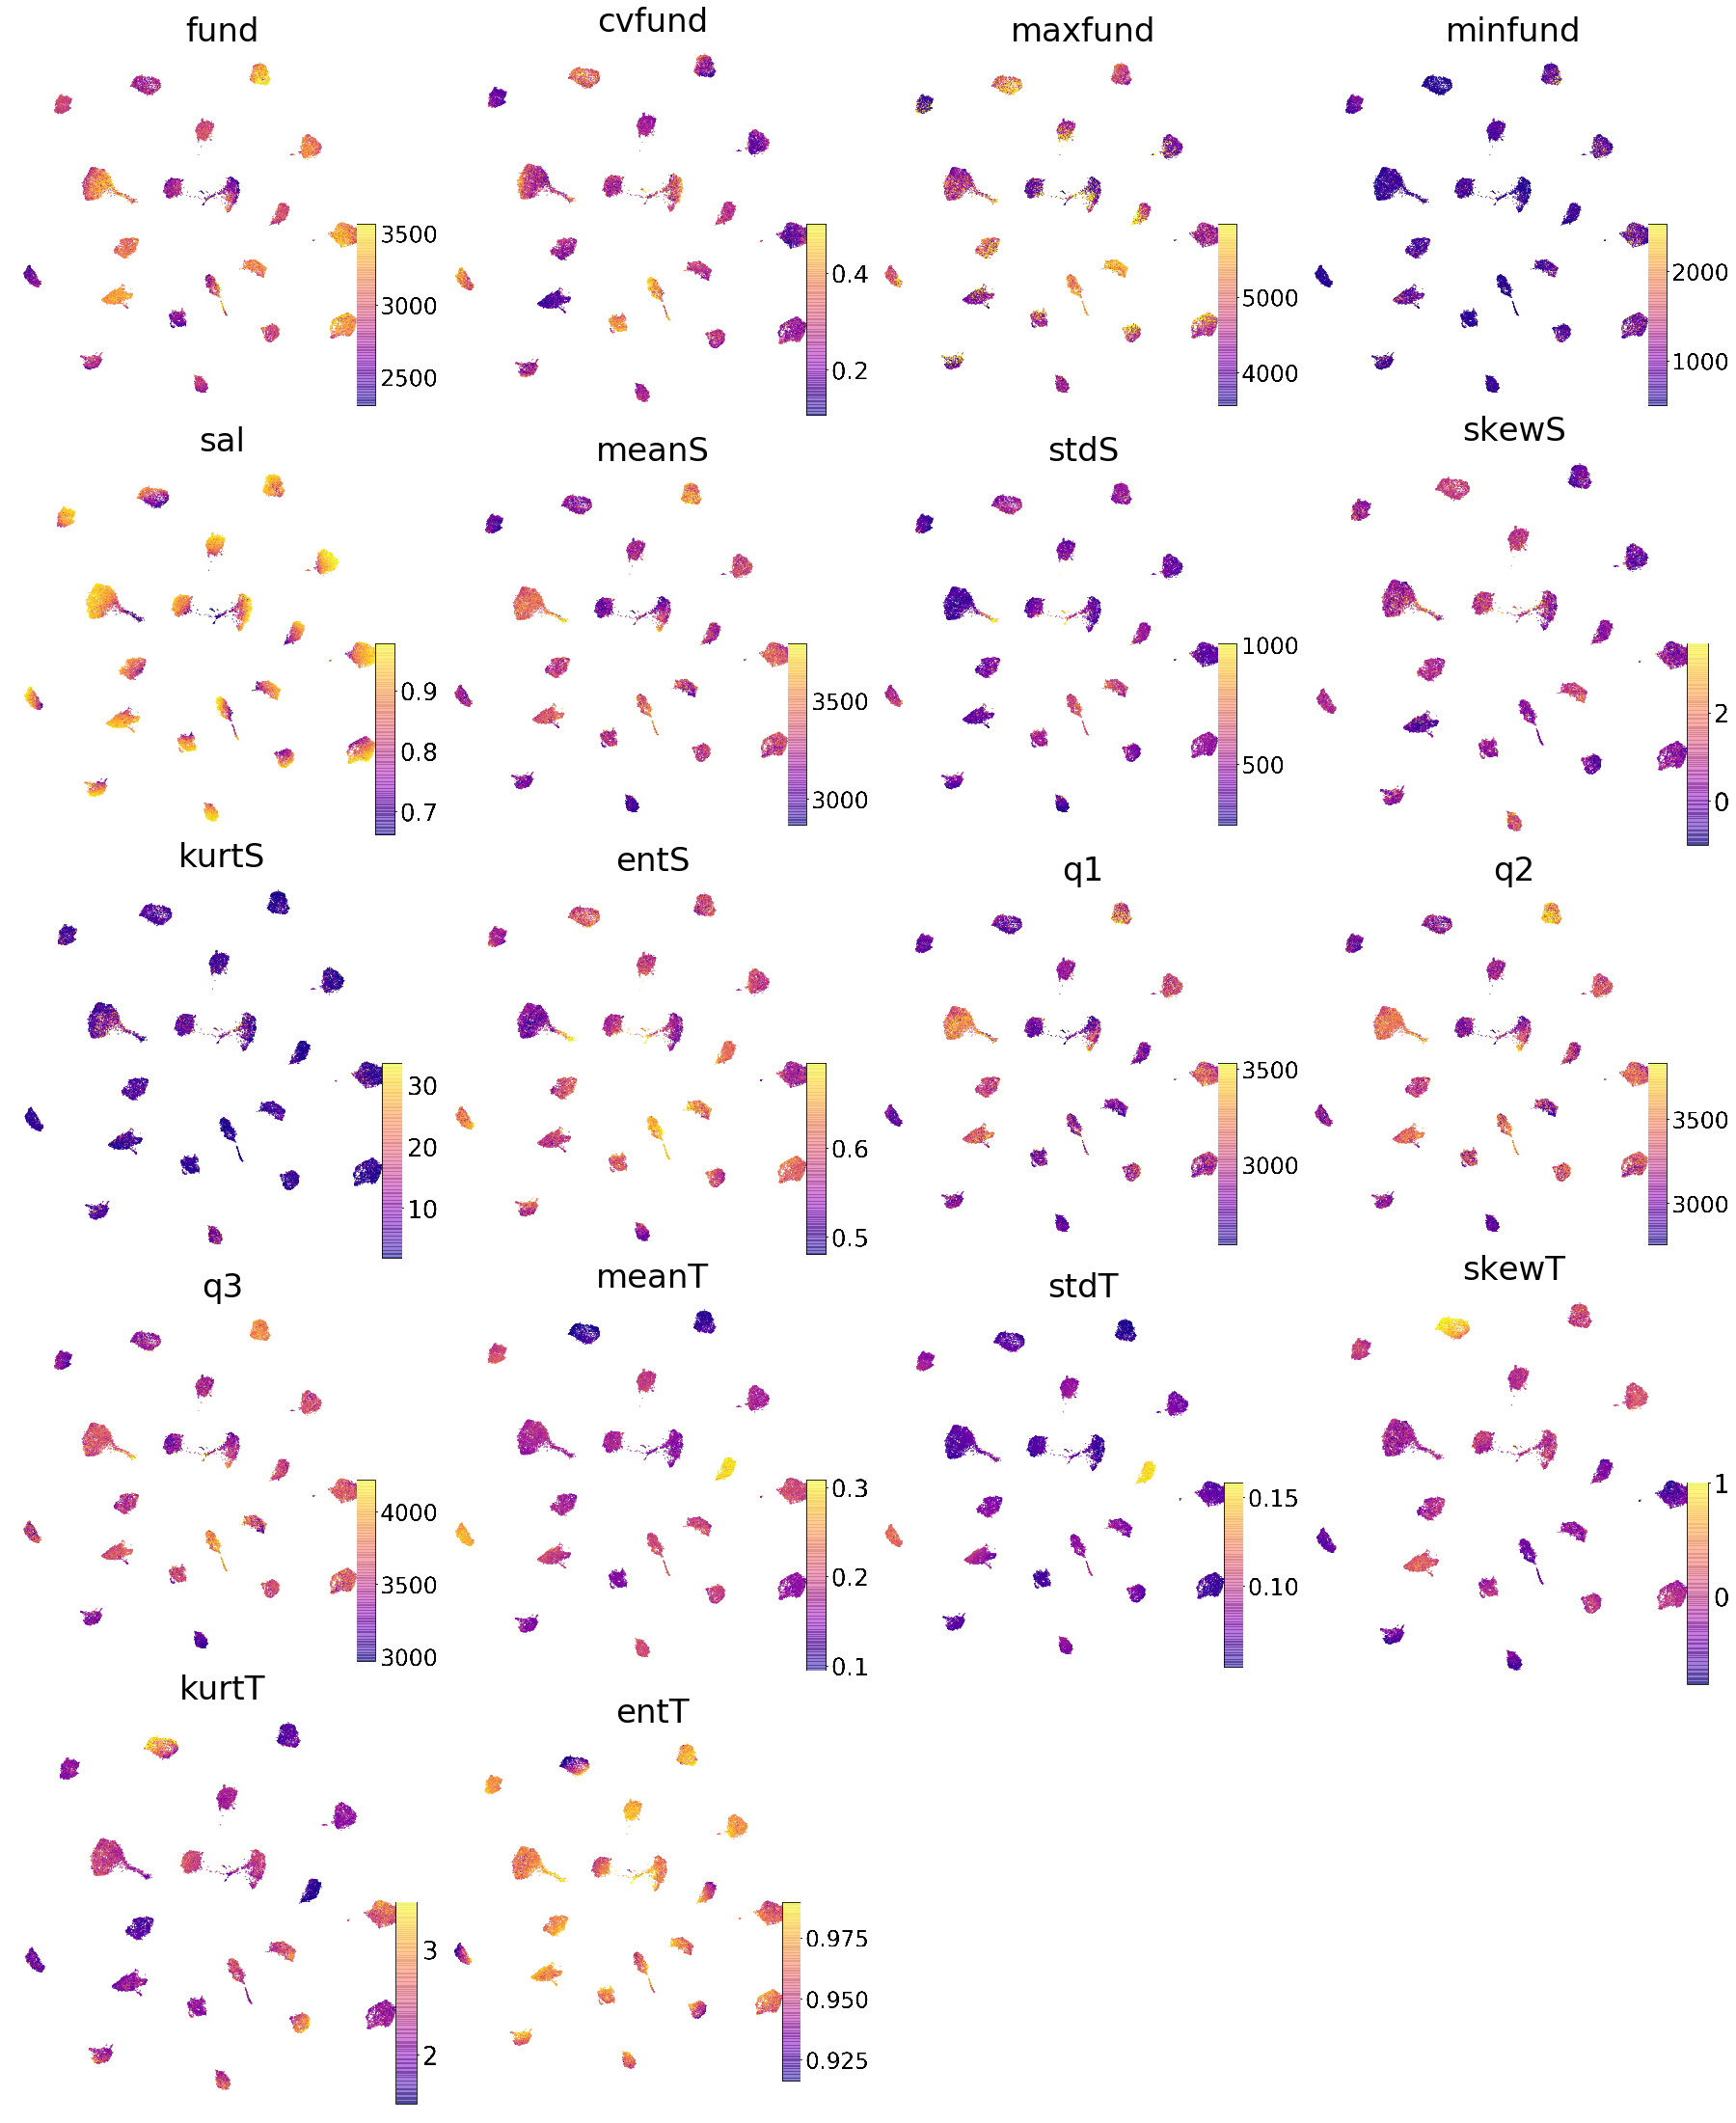

In [15]:
ncols = 4
nrows =5
zoom = 8
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, figsize=(zoom*ncols,nrows*zoom), gridspec_kw = {'wspace':0, 'hspace':0.0})
for fi, feature in tqdm(enumerate(features)):
    ax = axs.flatten()[fi]
    img=mpimg.imread((FIGURE_DIR / 'cassins-specs-vs-feats2' / 'feats_noborder' / (feature + '.jpg')).as_posix())
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(feature, fontsize=34)
    
for fi in range(fi, nrows*ncols):
    ax = axs.flatten()[fi]
    ax.axis('off')

ensure_dir(FIGURE_DIR / 'cassins-specs-vs-feats2')
save_fig(FIGURE_DIR / 'cassins-specs-vs-feats2' / 'umap_feats_proj', dpi=300, save_pdf=True)
plt.show()